In [1]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GaussianNoise


2024-10-24 15:24:59.589502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 15:24:59.711074: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 15:24:59.747628: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 15:24:59.978175: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 15:25:02.263730: W tensorflow/compiler/tf2

In [2]:
datadir = "data"

X_raw = []
Y = []
X_test_raw = []
Y_test = []

# control
files = os.listdir(os.path.join(datadir, "ctrl"))
files.sort()
for file in files:
    path = os.path.join(datadir, "ctrl", file)
    df = pl.read_csv(path, has_header=False, columns=[0], separator=";")
    X_raw.append(np.reshape(df.to_numpy(), (-1,)))
    Y.append(np.array([1.0, 0.0]))

# positive
files = os.listdir(os.path.join(datadir, "pt"))
files.sort()
for file in files:
    path = os.path.join(datadir, "pt", file)
    df = pl.read_csv(path, has_header=False, columns=[0], separator=";")
    X_raw.append(np.reshape(df.to_numpy(), (-1,)))
    Y.append(np.array([0.0, 1.0]))

# validation
files = os.listdir(os.path.join(datadir, "v"))
files.sort()
for file in files:
    path = os.path.join(datadir, "v", file)
    df = pl.read_csv(path, has_header=False, columns=[0], separator=";")
    X_test_raw.append(np.reshape(df.to_numpy(), (-1,)))
    Y_test.append(np.array([0.0, 1.0]) if 'd' in file else np.array([1.0, 0.0]))

assert len(X_raw) == len(Y)
assert len(X_test_raw) == len(Y_test)
assert len(X_raw[0]) == len(X_test_raw[0])
assert len(Y[0]) == len(Y_test[0])

print("Training samples:", len(X_raw))
print("Testing samples: ", len(X_test_raw))


Training samples: 57
Testing samples:  6


In [3]:
sample_freq = 2000      # Hz
sample_period = 1/2000  # s
signal_length = len(X_raw[0]) * sample_period


[1. 0.]


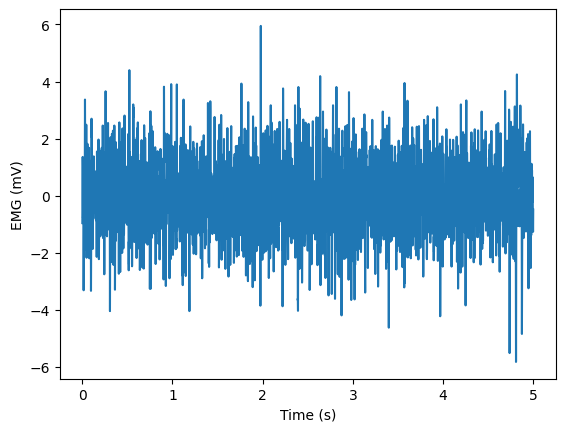

[0. 1.]


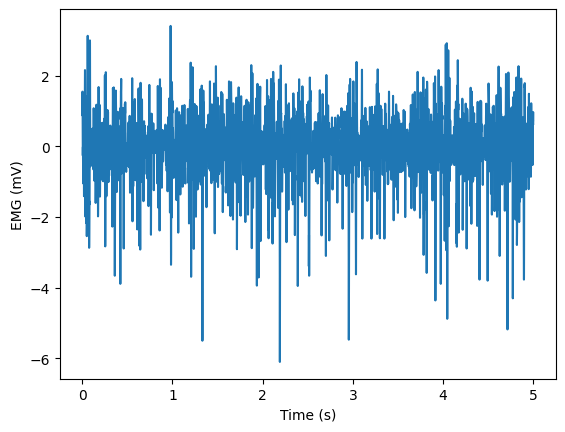

In [4]:
print(Y[0])
plt.plot(np.linspace(0, sample_period * len(X_raw[0]), len(X_raw[0])), 1e3 * X_raw[0])
plt.xlabel("Time (s)")
plt.ylabel("EMG (mV)")
plt.show()

print(Y[-1])
plt.plot(np.linspace(0, sample_period * len(X_raw[-1]), len(X_raw[-1])), 1e3 * X_raw[-1])
plt.xlabel("Time (s)")
plt.ylabel("EMG (mV)")
plt.show()


In [5]:
def to_spectogram(x):
    # Configuration parameters
    nfft = 1024
    noverlap = 512 + 256 + 128
    window = np.hanning(nfft)  # Hanning window function

    # Calculate the step size based on the overlap
    step = nfft - noverlap

    # Pad the signal to handle the windowing properly
    pad_width = (step - (len(X_raw[-1]) - noverlap) % step) % step
    padded_signal = np.pad(X_raw[-1], (0, pad_width), mode='constant')

    # Generate the segments using stride tricks
    segments = np.lib.stride_tricks.sliding_window_view(padded_signal, nfft)[::step]

    # Apply the window function to each segment
    windowed_segments = segments * window

    # Compute the Fourier Transform and get the magnitude squared (power spectrogram)
    Zxx = np.abs(np.fft.rfft(windowed_segments, axis=1))**2

    # Scale to match the matplotlib output
    Sxx = (Zxx / (window.sum()**2)).T

    # Frequencies and time bins
    freqs = np.fft.rfftfreq(nfft, d=1/sample_freq)
    times = np.arange(segments.shape[0]) * step / sample_freq

    return Sxx


In [6]:
X_spec = [to_spectogram(x) for x in X_raw]
X_test_spec = [to_spectogram(x) for x in X_test_raw]

X_spec[0]


array([[8.00816469e-15, 1.11567995e-15, 3.34496271e-15, ...,
        1.19979363e-14, 1.69430478e-17, 1.24307880e-12],
       [4.49030992e-15, 1.10439910e-14, 2.12885784e-15, ...,
        1.22235580e-15, 9.07236458e-15, 1.46725249e-12],
       [5.62329277e-16, 8.35875736e-16, 2.97903018e-15, ...,
        1.35493931e-14, 6.53125191e-15, 1.50112065e-12],
       ...,
       [8.93888581e-15, 9.27637047e-15, 7.67867119e-15, ...,
        1.75599794e-15, 2.40351402e-15, 5.91417831e-15],
       [5.46824805e-15, 7.41877178e-15, 5.33600151e-15, ...,
        5.93353444e-16, 2.05424017e-15, 3.32667618e-15],
       [2.81087329e-15, 3.70386965e-15, 2.28750330e-15, ...,
        5.03442672e-16, 1.51207685e-15, 1.39325230e-14]])

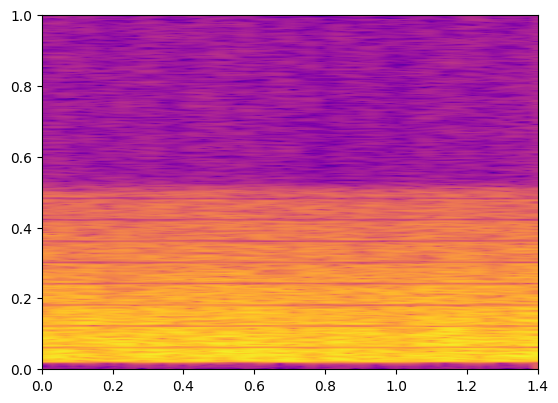

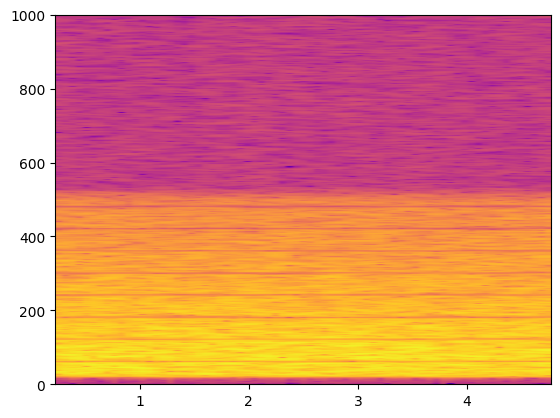

In [7]:
# Reshape the data to add the channel dimension (batch_size, height, width, channels)
X = np.log(np.array(X_spec).reshape(-1, 513, 72, 1))
Y = np.array(Y)
X_test = np.log(np.array(X_test_spec).reshape(-1, 513, 72, 1))
Y_test = np.array(Y_test)

plt.imshow(X[5,:,:,0], cmap='plasma', interpolation='bilinear', origin='lower', extent=[0, 1.4, 0, 1])
plt.show()

plt.specgram(X_raw[5], NFFT=1024, Fs=sample_freq, noverlap=1024-128, cmap='plasma')
plt.show()


The image above was generated as a comparison reference, to ensure the reshape is working as expected

In [8]:
""" # Define the CNN model
model = Sequential([
    Input((513, 72, 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='gelu'),
    Dense(64, activation='gelu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X, Y, epochs=50, batch_size=64, validation_data=(X_test, Y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict the probabilities for the test set
predictions = model.predict(X_test)
print(predictions)
 """


' # Define the CNN model\nmodel = Sequential([\n    Input((513, 72, 1)),\n    Conv2D(32, kernel_size=(3, 3), activation=\'relu\'),\n    MaxPooling2D(pool_size=(2, 2)),\n    Conv2D(64, kernel_size=(3, 3), activation=\'relu\'),\n    MaxPooling2D(pool_size=(2, 2)),\n    Flatten(),\n    Dense(128, activation=\'gelu\'),\n    Dense(64, activation=\'gelu\'),\n    Dropout(0.5),\n    Dense(2, activation=\'softmax\')  # Output layer with softmax for probability output\n])\n\n# Compile the model\nmodel.compile(optimizer=\'adam\', loss=\'categorical_crossentropy\', metrics=[\'accuracy\'])\n\n# Train the model\nmodel.fit(X, Y, epochs=50, batch_size=64, validation_data=(X_test, Y_test))\n\n# Evaluate the model\nloss, accuracy = model.evaluate(X_test, Y_test)\nprint(f"Test Accuracy: {accuracy * 100:.2f}%")\n\n# Predict the probabilities for the test set\npredictions = model.predict(X_test)\nprint(predictions)\n '

We started by trying to analyse the signal by pre-processing with a spectogram. This proved ineffective due to how the actual feature we want to analyze is the signal decay on people with the condition, and a spectrogram discards this type of information.

In [9]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


In [10]:
X_amp = np.array([moving_average(x, 20) for x in X_raw])
X_test_amp = np.array([moving_average(x, 20) for x in X_test_raw])

X_amp.shape


(57, 9982)

In [11]:
sample_count = len(X_amp[0])
X = np.array(X_amp).reshape(-1, sample_count)
Y = np.array(Y)
X_test = np.array(X_test_amp).reshape(-1, sample_count)
Y_test = np.array(Y_test)

(X.shape, Y.shape, X_test.shape, Y_test.shape)


((57, 9982), (57, 2), (6, 9982), (6, 2))

In [12]:
# Define the CNN model
model = Sequential([
    Input((sample_count,)),
    Dropout(0.99),
    GaussianNoise(1e-5),
    # Dense(1, activation='gelu'),
    # Dense(2, activation='gelu'),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['binary_accuracy', 'Precision', 'F1Score', 'Recall'])
model.fit(X, Y, epochs=100, batch_size=16, validation_data=(X_test, Y_test), verbose=2)

loss, accuracy, prec, f1, recall = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
print(f"Train Precision: {prec}")
print(f"Train Recall: {recall}")
print(f"Train F1Score: {f1}")
loss, accuracy, prec, f1, recall = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {prec}")
print(f"Test Recall: {recall}")
print(f"Test F1Score: {f1}")


I0000 00:00:1729794307.722472     931 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729794307.940403     931 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729794307.940555     931 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729794307.946784     931 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729794307.947425     931 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/100


I0000 00:00:1729794312.298319    1185 service.cc:146] XLA service 0x7f7518005000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729794312.298402    1185 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-10-24 15:25:12.370225: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-24 15:25:12.568992: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1729794316.049322    1185 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 - 10s - 2s/step - F1Score: 0.5960 - Precision: 0.5965 - Recall: 0.5965 - binary_accuracy: 0.5965 - loss: 0.6926 - val_F1Score: 0.6667 - val_Precision: 0.6667 - val_Recall: 0.6667 - val_binary_accuracy: 0.6667 - val_loss: 0.6928
Epoch 2/100
4/4 - 0s - 28ms/step - F1Score: 0.5403 - Precision: 0.5439 - Recall: 0.5439 - binary_accuracy: 0.5439 - loss: 0.6925 - val_F1Score: 0.8286 - val_Precision: 0.8333 - val_Recall: 0.8333 - val_binary_accuracy: 0.8333 - val_loss: 0.6924
Epoch 3/100
4/4 - 0s - 27ms/step - F1Score: 0.5920 - Precision: 0.5965 - Recall: 0.5965 - binary_accuracy: 0.5965 - loss: 0.6924 - val_F1Score: 0.6250 - val_Precision: 0.6667 - val_Recall: 0.6667 - val_binary_accuracy: 0.6667 - val_loss: 0.6919
Epoch 4/100
4/4 - 0s - 28ms/step - F1Score: 0.4751 - Precision: 0.4912 - Recall: 0.4912 - binary_accuracy: 0.4912 - loss: 0.6923 - val_F1Score: 0.6250 - val_Precision: 0.6667 - val_Recall: 0.6667 - val_binary_accuracy: 0.6667 - val_loss: 0.6915
Epoch 5/100
4/4 - 0s - 27ms/step 

In [13]:
# Extract features with PCA because 9982 is too many
from sklearn.decomposition import PCA

n_components = 8
pca = PCA(n_components=n_components)

X_amp_pca = pca.fit_transform(X_amp)
X_test_amp_pca = pca.transform(X_test_amp)

X_amp_pca.shape


(57, 8)

In [14]:
X = X_amp_pca
Y = np.array(Y)
X_test = X_test_amp_pca
Y_test = np.array(Y_test)

(X.shape, Y.shape, X_test.shape, Y_test.shape)


((57, 8), (57, 2), (6, 8), (6, 2))

In [15]:
# Define the CNN model
model = Sequential([
    Input((n_components,)),
    Dropout(0.2),
    GaussianNoise(1e-5),
    Dense(4, activation='gelu'),
    # Dense(3, activation='gelu'),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(X, Y, epochs=600, batch_size=16, validation_data=(X_test, Y_test), verbose=2)

loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/600
4/4 - 6s - 2s/step - binary_accuracy: 0.4737 - loss: 0.6923 - val_binary_accuracy: 0.3333 - val_loss: 0.6914
Epoch 2/600
4/4 - 0s - 21ms/step - binary_accuracy: 0.4211 - loss: 0.6925 - val_binary_accuracy: 0.5000 - val_loss: 0.6913
Epoch 3/600
4/4 - 0s - 21ms/step - binary_accuracy: 0.5088 - loss: 0.6919 - val_binary_accuracy: 0.6667 - val_loss: 0.6913
Epoch 4/600
4/4 - 0s - 21ms/step - binary_accuracy: 0.4737 - loss: 0.6926 - val_binary_accuracy: 0.6667 - val_loss: 0.6912
Epoch 5/600
4/4 - 0s - 20ms/step - binary_accuracy: 0.5614 - loss: 0.6914 - val_binary_accuracy: 0.6667 - val_loss: 0.6912
Epoch 6/600
4/4 - 0s - 19ms/step - binary_accuracy: 0.5965 - loss: 0.6913 - val_binary_accuracy: 0.6667 - val_loss: 0.6911
Epoch 7/600
4/4 - 0s - 19ms/step - binary_accuracy: 0.5614 - loss: 0.6916 - val_binary_accuracy: 0.6667 - val_loss: 0.6911
Epoch 8/600
4/4 - 0s - 19ms/step - binary_accuracy: 0.5439 - loss: 0.6919 - val_binary_accuracy: 0.6667 - val_loss: 0.6910
Epoch 9/600
4/4 - 

|Layers|Loss|Accuracy|
|------|----|--------|
|4     |0.55|100%    |
|4,4   |0.20|100%    |
|6,2   |0.26|100%    |
|8     |0.42|100%    |

In [16]:
print(model.predict(X_test))
Y_test[:,1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
[[0.4121129  0.5878871 ]
 [0.04182393 0.958176  ]
 [0.3089528  0.6910472 ]
 [0.6925315  0.30746847]
 [0.83814585 0.16185413]
 [0.78862613 0.21137394]]


array([1., 1., 1., 0., 0., 0.])

In [17]:
Y[0,:]


array([1., 0.])

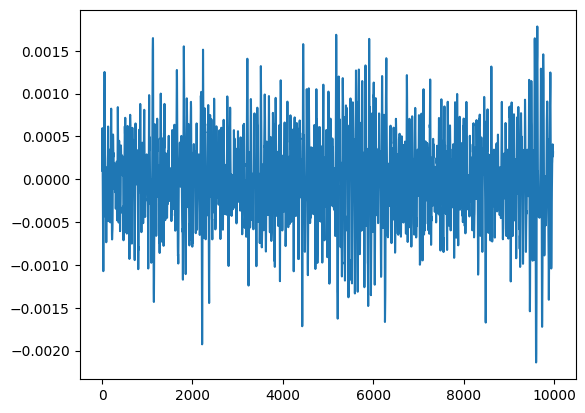

In [18]:
plt.plot(X_amp[1,:])


In [19]:
X_samp = np.array([moving_average(x**2, 20) for x in X_raw])
X_test_samp = np.array([moving_average(x**2, 20) for x in X_test_raw])

X_samp.shape


(57, 9982)

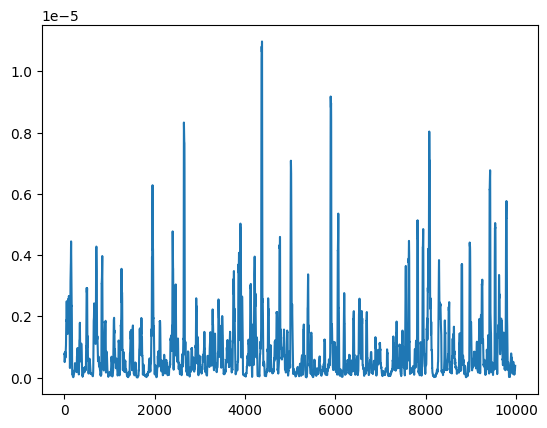

In [20]:
plt.plot(X_samp[-1,:])


In [21]:
from sklearn.decomposition import PCA

n_components = 10
pca = PCA(n_components=n_components)

X_samp_pca = pca.fit_transform(X_samp)
X_test_samp_pca = pca.transform(X_test_samp)

X_samp_pca.shape


(57, 10)

In [22]:
X = X_samp_pca
Y = np.array(Y)
X_test = X_test_samp_pca
Y_test = np.array(Y_test)

(X.shape, Y.shape, X_test.shape, Y_test.shape)


((57, 10), (57, 2), (6, 10), (6, 2))

In [23]:
# Define the CNN model
model = Sequential([
    Input((n_components,)),
    # Dropout(0.2),
    # GaussianNoise(1e-5),
    Dense(4, activation='gelu'),
    # Dense(3, activation='gelu'),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(X, Y, epochs=400, batch_size=16, validation_data=(X_test, Y_test), verbose=2)

loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/400
4/4 - 4s - 955ms/step - binary_accuracy: 0.4912 - loss: 0.6932 - val_binary_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/400
4/4 - 0s - 20ms/step - binary_accuracy: 0.5263 - loss: 0.6930 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/400
4/4 - 0s - 22ms/step - binary_accuracy: 0.5263 - loss: 0.6931 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/400
4/4 - 0s - 21ms/step - binary_accuracy: 0.5263 - loss: 0.6929 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/400
4/4 - 0s - 23ms/step - binary_accuracy: 0.5263 - loss: 0.6929 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/400
4/4 - 0s - 21ms/step - binary_accuracy: 0.5263 - loss: 0.6928 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/400
4/4 - 0s - 22ms/step - binary_accuracy: 0.5263 - loss: 0.6928 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/400
4/4 - 0s - 21ms/step - binary_accuracy: 0.5263 - loss: 0.6928 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 9/400
4/4

Dessa forma podemos ver como a análise do sinal por si só possui algum tipo de informação que é perdida quando tiramos o quadrado do sinal. Vamos analisar se com uma média corrente de janela maior ainda teremos uma boa performance com a primeira técnica.

In [24]:
X_amp = np.array([moving_average(x, 200) for x in X_raw])
X_test_amp = np.array([moving_average(x, 200) for x in X_test_raw])

X_amp.shape

sample_count = len(X_amp[0])
X = np.array(X_amp).reshape(-1, sample_count)
Y = np.array(Y)
X_test = np.array(X_test_amp).reshape(-1, sample_count)
Y_test = np.array(Y_test)

(X.shape, Y.shape, X_test.shape, Y_test.shape)


((57, 9802), (57, 2), (6, 9802), (6, 2))

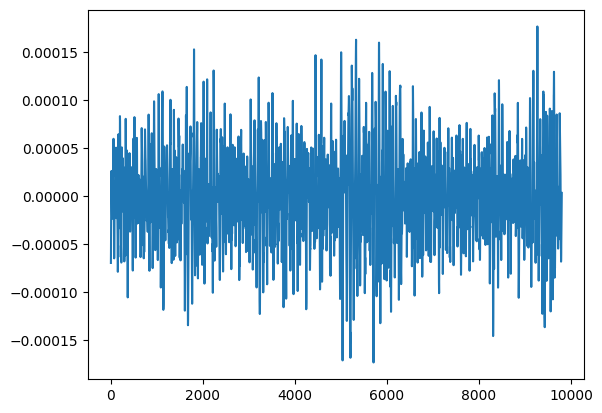

In [36]:
plt.plot(X_amp[1,:])


In [34]:
# Define the CNN model
model = Sequential([
    Input((sample_count,)),
    Dropout(0.99),
    GaussianNoise(1e-5),
    Dense(1, activation='gelu'),
    # Dense(2, activation='gelu'),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(X, Y, epochs=2000, batch_size=32, validation_data=(X_test, Y_test), verbose=2)

loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/2000
2/2 - 3s - 1s/step - binary_accuracy: 0.5789 - loss: 0.6931 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/2000
2/2 - 0s - 18ms/step - binary_accuracy: 0.5263 - loss: 0.6931 - val_binary_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/2000
2/2 - 0s - 18ms/step - binary_accuracy: 0.5263 - loss: 0.6930 - val_binary_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/2000
2/2 - 0s - 18ms/step - binary_accuracy: 0.5263 - loss: 0.6930 - val_binary_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/2000
2/2 - 0s - 17ms/step - binary_accuracy: 0.5263 - loss: 0.6930 - val_binary_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/2000
2/2 - 0s - 18ms/step - binary_accuracy: 0.5263 - loss: 0.6929 - val_binary_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/2000
2/2 - 0s - 19ms/step - binary_accuracy: 0.5263 - loss: 0.6928 - val_binary_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/2000
2/2 - 0s - 18ms/step - binary_accuracy: 0.5263 - loss: 0.6929 - val_binary_accuracy: 0.5000 - val_loss: 0.6931
Epoch 9/20

Percebemos que ainda é possível aprender a classificar os dados, mas dado que é necessário muito mais tempo para ajustar o modelo aos dados, concluímos que estes dados são menos representativos.

In [37]:
X_amp = np.array(X_raw)
X_test_amp = np.array(X_test_raw)

X_amp.shape

sample_count = len(X_amp[0])
X = np.array(X_amp).reshape(-1, sample_count)
Y = np.array(Y)
X_test = np.array(X_test_amp).reshape(-1, sample_count)
Y_test = np.array(Y_test)

(X.shape, Y.shape, X_test.shape, Y_test.shape)


((57, 10001), (57, 2), (6, 10001), (6, 2))

In [40]:
# Define the CNN model
model = Sequential([
    Input((sample_count,)),
    Dropout(0.8),
    GaussianNoise(1e-5),
    # Dense(1, activation='gelu'),
    # Dense(2, activation='gelu'),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(X, Y, epochs=50, batch_size=16, validation_data=(X_test, Y_test), verbose=2)

loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/50
4/4 - 2s - 561ms/step - binary_accuracy: 0.5088 - loss: 0.6932 - val_binary_accuracy: 0.6667 - val_loss: 0.6904
Epoch 2/50
4/4 - 0s - 9ms/step - binary_accuracy: 0.9649 - loss: 0.6895 - val_binary_accuracy: 1.0000 - val_loss: 0.6876
Epoch 3/50
4/4 - 0s - 10ms/step - binary_accuracy: 1.0000 - loss: 0.6866 - val_binary_accuracy: 1.0000 - val_loss: 0.6848
Epoch 4/50
4/4 - 0s - 9ms/step - binary_accuracy: 1.0000 - loss: 0.6840 - val_binary_accuracy: 1.0000 - val_loss: 0.6820
Epoch 5/50
4/4 - 0s - 9ms/step - binary_accuracy: 1.0000 - loss: 0.6809 - val_binary_accuracy: 1.0000 - val_loss: 0.6793
Epoch 6/50
4/4 - 0s - 9ms/step - binary_accuracy: 1.0000 - loss: 0.6781 - val_binary_accuracy: 1.0000 - val_loss: 0.6766
Epoch 7/50
4/4 - 0s - 10ms/step - binary_accuracy: 1.0000 - loss: 0.6757 - val_binary_accuracy: 1.0000 - val_loss: 0.6738
Epoch 8/50
4/4 - 0s - 9ms/step - binary_accuracy: 1.0000 - loss: 0.6726 - val_binary_accuracy: 1.0000 - val_loss: 0.6711
Epoch 9/50
4/4 - 0s - 9ms/st

Podemos ver que comparando os modelos com e sem média corrente, sem a média temos um ajuste quase que instantâneo. Com isso, entendemos que a média corrente "apaga" dados muito representativos.

In [54]:
n_components = 6
pca = PCA(n_components=n_components)

X_amp_pca = pca.fit_transform(X_amp)
X_test_amp_pca = pca.transform(X_test_amp)

X = X_amp_pca
Y = np.array(Y)
X_test = X_test_amp_pca
Y_test = np.array(Y_test)

print(X.shape, Y.shape, X_test.shape, Y_test.shape)

model = Sequential([
    Input((n_components,)),
    Dropout(0.01),
    GaussianNoise(1e-6),
    # Dense(1, activation='gelu'),
    # Dense(2, activation='gelu'),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(X, Y, epochs=1000, batch_size=16, validation_data=(X_test, Y_test), verbose=2)

loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


(57, 6) (57, 2) (6, 6) (6, 2)
Epoch 1/1000
4/4 - 2s - 562ms/step - binary_accuracy: 0.7368 - loss: 0.6844 - val_binary_accuracy: 0.6667 - val_loss: 0.6867
Epoch 2/1000
4/4 - 0s - 9ms/step - binary_accuracy: 0.7368 - loss: 0.6840 - val_binary_accuracy: 0.6667 - val_loss: 0.6866
Epoch 3/1000
4/4 - 0s - 9ms/step - binary_accuracy: 0.7368 - loss: 0.6840 - val_binary_accuracy: 0.6667 - val_loss: 0.6866
Epoch 4/1000
4/4 - 0s - 8ms/step - binary_accuracy: 0.7368 - loss: 0.6839 - val_binary_accuracy: 0.6667 - val_loss: 0.6865
Epoch 5/1000
4/4 - 0s - 9ms/step - binary_accuracy: 0.7368 - loss: 0.6834 - val_binary_accuracy: 0.6667 - val_loss: 0.6864
Epoch 6/1000
4/4 - 0s - 9ms/step - binary_accuracy: 0.7368 - loss: 0.6836 - val_binary_accuracy: 0.6667 - val_loss: 0.6863
Epoch 7/1000
4/4 - 0s - 9ms/step - binary_accuracy: 0.7544 - loss: 0.6833 - val_binary_accuracy: 0.6667 - val_loss: 0.6863
Epoch 8/1000
4/4 - 0s - 9ms/step - binary_accuracy: 0.7719 - loss: 0.6835 - val_binary_accuracy: 0.6667 - v

In [55]:
model = Sequential([
    Input((n_components,)),
    Dropout(0.5),
    GaussianNoise(1e-5),
    # Dense(1, activation='gelu'),
    Dense(2, activation='gelu'),
    GaussianNoise(1e-5),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(X, Y, epochs=300, batch_size=16, validation_data=(X_test, Y_test), verbose=2)

loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/300
4/4 - 3s - 777ms/step - binary_accuracy: 0.6316 - loss: 0.6855 - val_binary_accuracy: 0.6667 - val_loss: 0.6890
Epoch 2/300
4/4 - 0s - 9ms/step - binary_accuracy: 0.5965 - loss: 0.6881 - val_binary_accuracy: 0.6667 - val_loss: 0.6890
Epoch 3/300
4/4 - 0s - 9ms/step - binary_accuracy: 0.6491 - loss: 0.6861 - val_binary_accuracy: 0.6667 - val_loss: 0.6889
Epoch 4/300
4/4 - 0s - 9ms/step - binary_accuracy: 0.6316 - loss: 0.6868 - val_binary_accuracy: 0.6667 - val_loss: 0.6888
Epoch 5/300
4/4 - 0s - 10ms/step - binary_accuracy: 0.5789 - loss: 0.6891 - val_binary_accuracy: 0.6667 - val_loss: 0.6887
Epoch 6/300
4/4 - 0s - 9ms/step - binary_accuracy: 0.5965 - loss: 0.6859 - val_binary_accuracy: 0.8333 - val_loss: 0.6886
Epoch 7/300
4/4 - 0s - 9ms/step - binary_accuracy: 0.6842 - loss: 0.6851 - val_binary_accuracy: 0.8333 - val_loss: 0.6885
Epoch 8/300
4/4 - 0s - 9ms/step - binary_accuracy: 0.5789 - loss: 0.6885 - val_binary_accuracy: 0.6667 - val_loss: 0.6884
Epoch 9/300
4/4 - 0s 

In [56]:
X_amp_pca.shape


(57, 6)

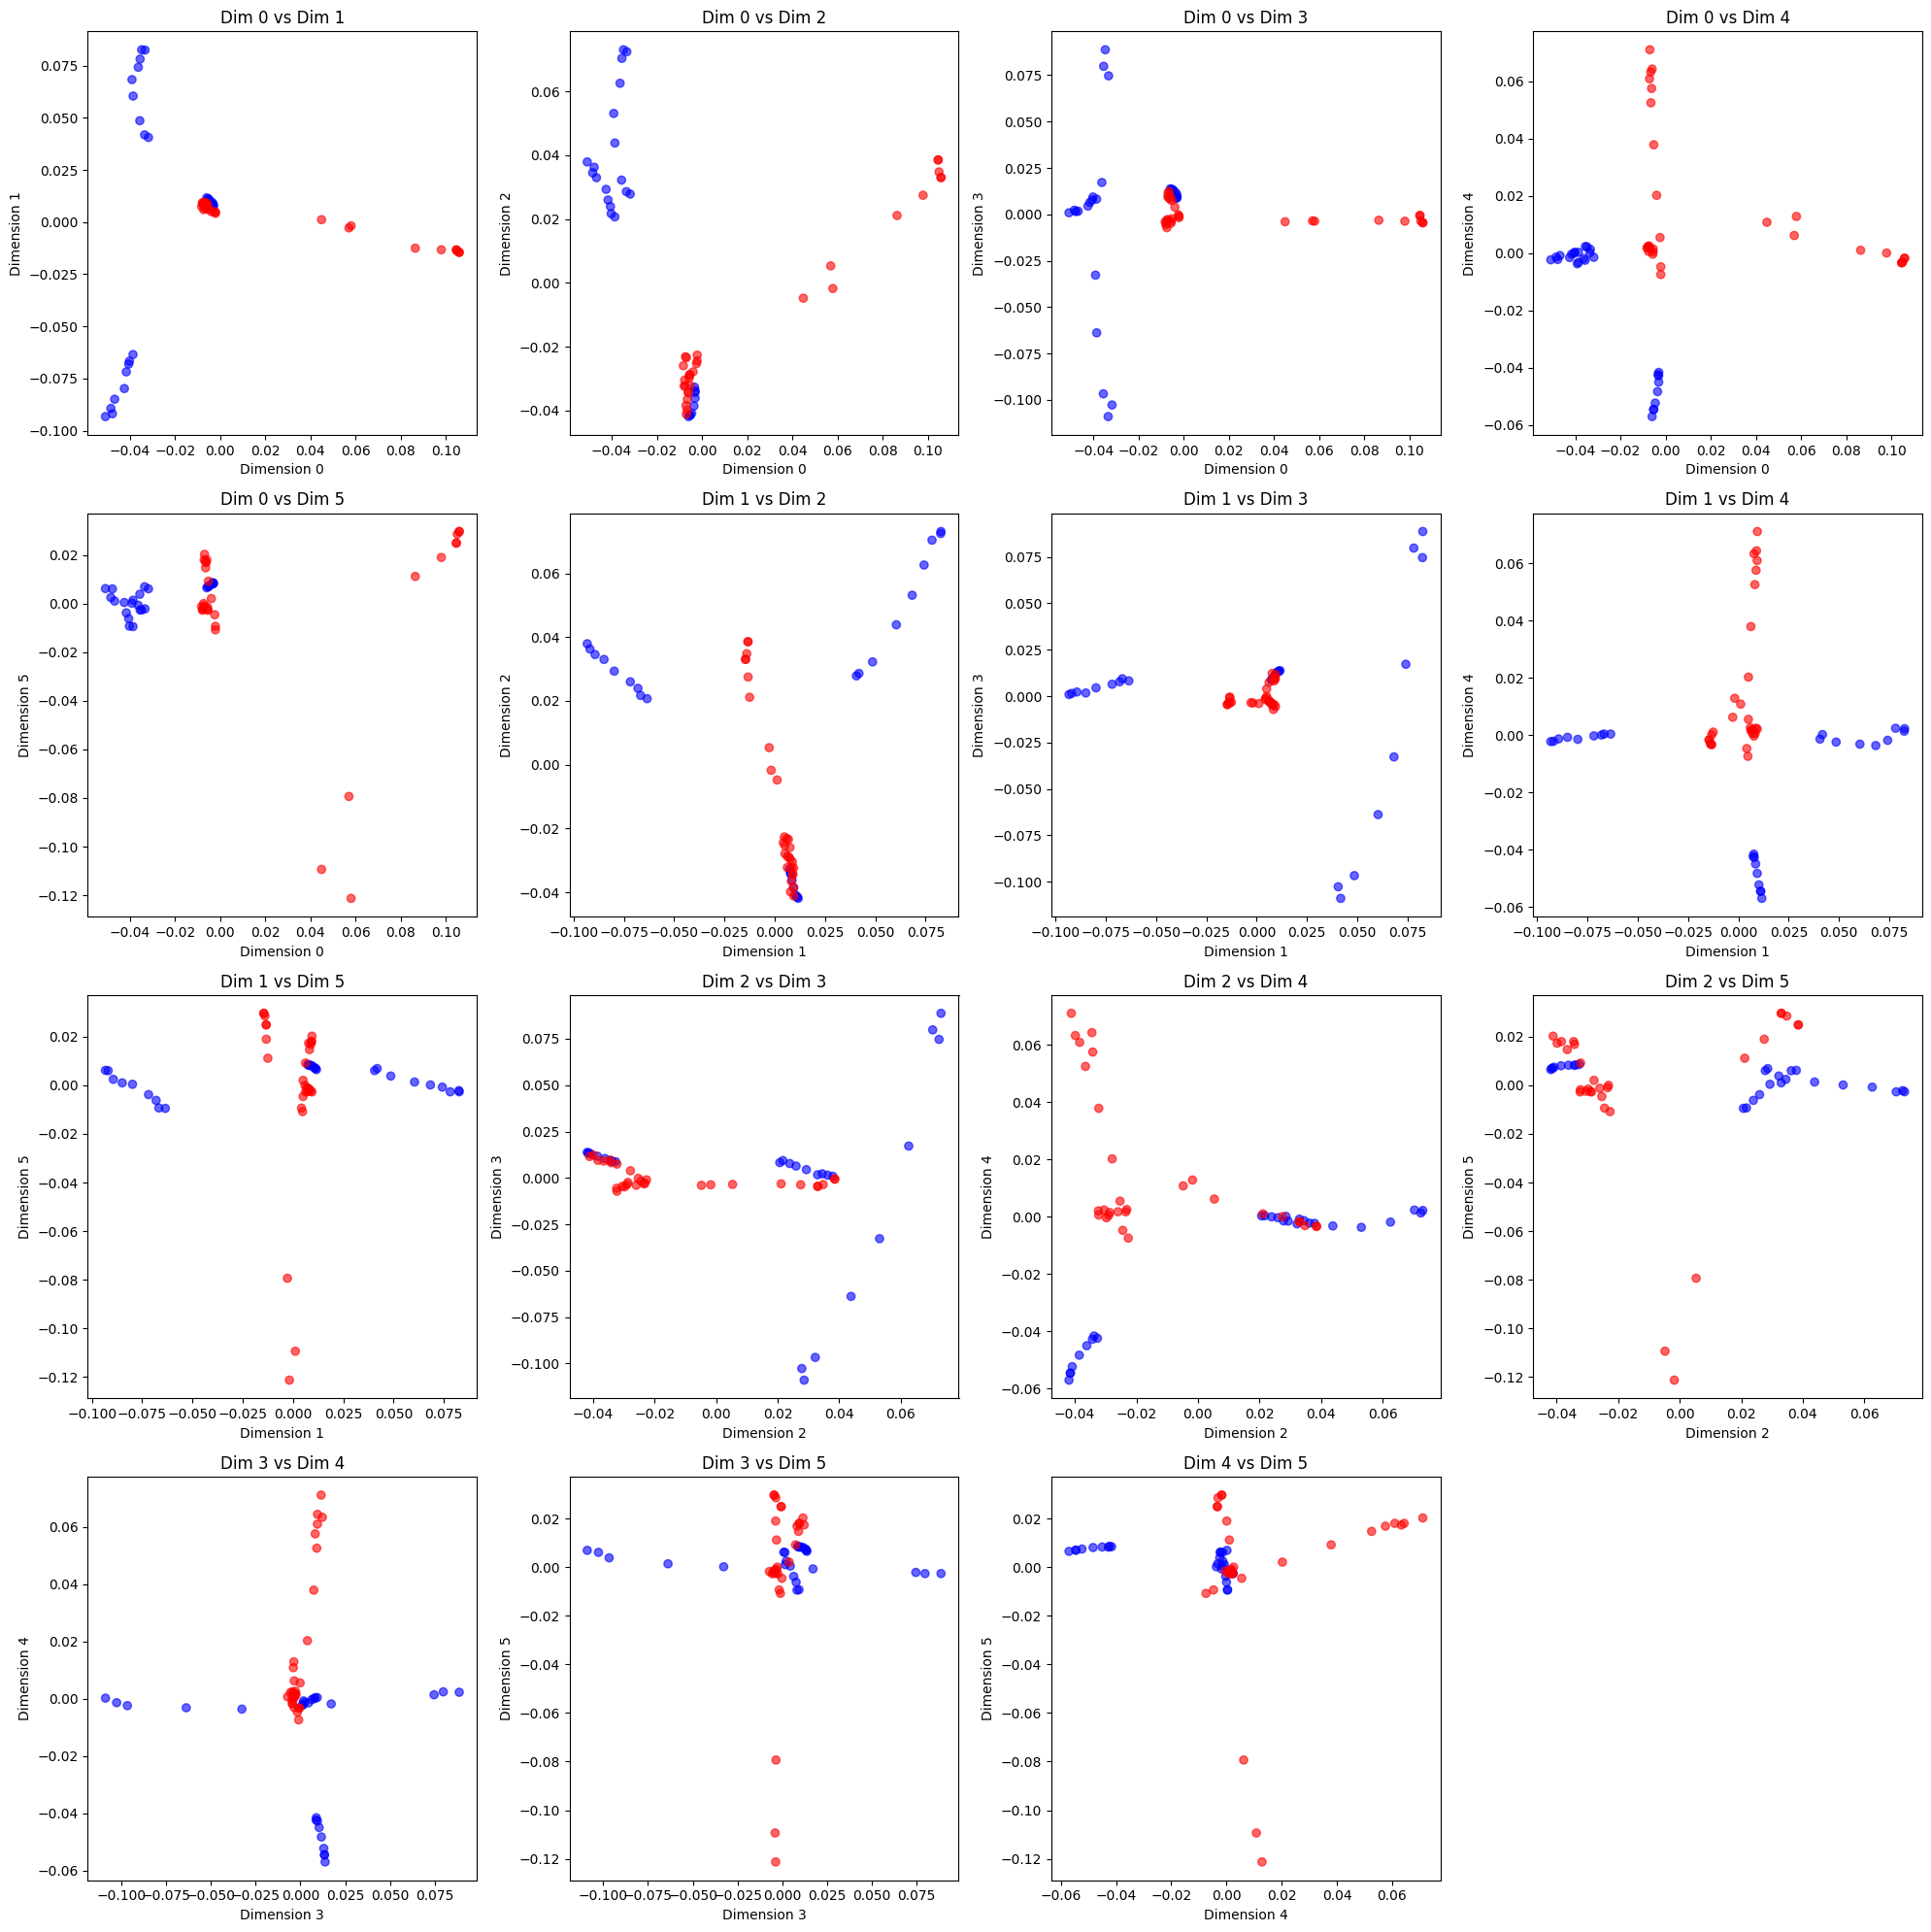

In [58]:
import matplotlib.pyplot as plt
import itertools
import numpy as np

def plot_dimension_pairs(X, Y):
    num_dims = X.shape[1]  # Get the number of dimensions in X
    dimension_pairs = list(itertools.combinations(range(num_dims), 2))  # Generate all 2D pairs
    num_pairs = len(dimension_pairs)

    # Generate color labels based on the Y matrix
    colors = ['blue' if label[0] == 1 else 'red' for label in Y]

    # Determine the grid size for subplots
    n_cols = 4
    n_rows = (num_pairs + n_cols - 1) // n_cols  # Round up to ensure all plots fit

    # Plotting all pairs
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten()

    for idx, (dim1, dim2) in enumerate(dimension_pairs):
        ax = axes[idx]
        ax.scatter(X[:, dim1], X[:, dim2], c=colors, alpha=0.6)
        ax.set_xlabel(f'Dimension {dim1}')
        ax.set_ylabel(f'Dimension {dim2}')
        ax.set_title(f'Dim {dim1} vs Dim {dim2}')

    # Hide any unused subplots
    for i in range(num_pairs, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# Example usage with your matrices
plot_dimension_pairs(X_amp_pca, Y)


In [80]:
X = X_amp_pca[:, (1, 4)]
X_test = X_test_amp_pca[:, (1, 4)]

model = Sequential([
    Input((2,)),
    # GaussianNoise(1e-5),
    Dense(16, activation='gelu'),
    # Dropout(0.4),
    Dense(8, activation='gelu'),
    # GaussianNoise(1e-5),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(X, Y, epochs=2000, batch_size=16, validation_data=(X_test, Y_test), verbose=2)

loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/2000
4/4 - 3s - 637ms/step - binary_accuracy: 0.4912 - loss: 0.6934 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/2000
4/4 - 0s - 10ms/step - binary_accuracy: 0.5263 - loss: 0.6931 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/2000
4/4 - 0s - 11ms/step - binary_accuracy: 0.5263 - loss: 0.6930 - val_binary_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/2000
4/4 - 0s - 11ms/step - binary_accuracy: 0.5263 - loss: 0.6929 - val_binary_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/2000
4/4 - 0s - 11ms/step - binary_accuracy: 0.5263 - loss: 0.6928 - val_binary_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/2000
4/4 - 0s - 10ms/step - binary_accuracy: 0.5263 - loss: 0.6927 - val_binary_accuracy: 0.5000 - val_loss: 0.6930
Epoch 7/2000
4/4 - 0s - 10ms/step - binary_accuracy: 0.5263 - loss: 0.6925 - val_binary_accuracy: 0.5000 - val_loss: 0.6930
Epoch 8/2000
4/4 - 0s - 10ms/step - binary_accuracy: 0.5263 - loss: 0.6924 - val_binary_accuracy: 0.5000 - val_loss: 0.6929
Epoch 9

Com isso, concluímos que por mais que o sinal seja bem representado

# Testes com outros classificadores

In [ ]:
def get_average_change(array):
    x = np.linspace(0, 1, len(array)-1)
    arr = (array[1:]-array[:-1]) * x * (1 - x) * 6
    return sum(arr)



def extract_features(arrays):
    features = []
    for array in arrays:
        mean = np.mean(array)
        std = np.std(array)
        min_val = np.min(array)
        max_val = np.max(array)
        median = np.median(array)
        range_val = max_val - min_val
        q1 = np.percentile(array, 25)
        q3 = np.percentile(array, 75)

        half = len(array)//2
        start_median = np.median(array[:half])
        end_median = np.median(array[half:])

        mean_square = np.mean(array ** 2)
        change = get_average_change(array)

        features.append({
            "mean": mean,
            "std": std,
            "min": min_val,
            "max": max_val,
            "median": median,
            "range": range_val,
            "q1": q1,
            "q3": q3,
            "start_median": start_median,
            "end_median": end_median,
            "mean_square": mean_square,
            "avg_change": change,
        })

    features = pl.DataFrame(features)
    return features


### Creating Feature Set

In [ ]:
feature_set = extract_features(X_raw)
feature_set_val = extract_features(X_test_raw)


### Y Flatenning

In [ ]:
Y_transformed = np.argmax(Y, axis=1)
Y_test_transformed = np.argmax(Y_test, axis=1)


## Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(feature_set, Y)
y_pred = clf.predict(feature_set_val)

print("Accuracy:", accuracy_score(Y_test, y_pred))
print("Classification Report:\n", classification_report(Y_test, y_pred))


## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(feature_set, Y)
knn_pred = knn_model.predict(feature_set_val)

print("Accuracy:", accuracy_score(Y_test, knn_pred))
print("Classification Report:\n", classification_report(Y_test, knn_pred))


## Support Vector Machines (SVM)

In [ ]:
from sklearn.svm import SVC
svm_model = SVC(kernel='linear', C=1.0)  # Linear kernel
svm_model.fit(feature_set, Y_transformed)
svm_pred = svm_model.predict(feature_set_val)

print("Accuracy:", accuracy_score(Y_test_transformed, svm_pred))
print("Classification Report:\n", classification_report(Y_test_transformed, svm_pred))


### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(feature_set, Y_transformed)
nb_pred = nb_model.predict(feature_set_val)

print("Accuracy:", accuracy_score(Y_test_transformed, nb_pred))
print("Classification Report:\n", classification_report(Y_test_transformed, nb_pred))
